# Linear Regression, XGBoost, and LSTM

In [3]:
from src import data
from src import mlp

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In this notebook, we implement as a baseline various wave height prediction methods that leverage our data. We will begin with simple linear regression, examining different hyperparameters and regularization methods, then move into other prediction methods such as XGBoost.

### Collecting Data

In [4]:
# Buouy data paths for wave related measurements
DATA_PATH_2022 = 'data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = 'data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = 'data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = 'data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = 'data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = 'data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = 'data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = 'data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = 'data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = 'data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = 'data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = 'data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = 'data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = 'data/targetstation46240/46240h2009.txt'

We first consolidate all of our datapaths into one list to read them all into a large pandas dataframe for later examination. Our `station46240specs` represent the measurements that buoy 46240 off of Cabrillo Point in Monterey Bay, CA, are equipped to read.

In [5]:
file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

station46240specs = ['WVHT', 'DPD', 'APD', 'MWD']

# Re-reading and combining data from all files with outliers replaced by NaN
all_wave_data_46240 = pd.concat([data.process_file_to_hourly_last(file) for file in file_paths])

all_wave_data_46240.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE', 'ATMP'], inplace=True)

all_wave_data_46240.shape

(116706, 9)

Our data is formatted below. As we can see, we processed it to contain data measured hourly starting in 2009 going all the way to the end of 2022. 

In [6]:
all_wave_data_46240[all_wave_data_46240.isnull().any(axis=1)]

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-04-06 23:00:00,2009,4,6,23,0.96,15.38,11.37,7.0,NaN
2009-04-07 00:00:00,2009,4,7,0,0.83,11.76,10.87,354.0,NaN
2009-04-08 01:00:00,2009,4,8,1,0.87,12.50,10.72,352.0,NaN
2009-04-08 02:00:00,2009,4,8,2,0.88,11.76,10.62,347.0,NaN
2009-04-08 03:00:00,2009,4,8,3,0.75,11.76,10.31,349.0,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-31 08:00:00,2022,8,31,8,0.20,NaN,5.65,NaN,15.7
2022-08-31 09:00:00,2022,8,31,9,0.21,NaN,5.84,NaN,15.6
2022-08-31 10:00:00,2022,8,31,10,0.23,NaN,5.85,NaN,15.6


The buoy unfortunately experiences gaps in its recording of some datapoints (which are represented as `NaN`) so we will drop those, leaving us with 116,387 datapoints, each with 5 features: wave height, dominiant wave period (DPD), average wave period (APD), direction of dominant wave period (MWD), and sea surface temperature (WTMP).

In [7]:
# drop rows that contain NaN values
all_wave_data_46240.dropna(inplace=True)
print(all_wave_data_46240.shape)
final_df = all_wave_data_46240.copy()
final_df.head()

(116387, 9)


,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,1.12,11.76,7.91,352.0,11.9
2009-01-01 01:00:00,2009,1,1,1,1.02,10.53,6.31,346.0,11.9
2009-01-01 02:00:00,2009,1,1,2,1.07,11.11,5.61,352.0,11.9
2009-01-01 03:00:00,2009,1,1,3,1.14,11.76,5.42,352.0,11.9
2009-01-01 04:00:00,2009,1,1,4,1.00,13.33,5.65,359.0,11.9


### Splitting the Data

We now split the data into a training set, a validation set, and a testing set. Our training set will contain hourly data from 2009 to 2018, our validation set will hold 2019 and 2020, and our testing set will contain 2021 and 2022. 

In [8]:
train_df = final_df[final_df.index.year <= 2018]
val_df = final_df[(final_df.index.year == 2019) | (final_df.index.year == 2020)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df = final_df[(final_df.index.year == 2021) | (final_df.index.year == 2022)]

Due to some measurements not being sequential, we use `check_for_missing_rows` to further format our data to be sequential, hourly data. As we can see, there are 614 missing indices in our training, 49 in our validation, and 16 in our test, so we will remove them.

In [9]:
missing_indices_train = data.check_for_missing_rows(train_df)
len(missing_indices_train)

614

In [10]:
missing_indices_val = data.check_for_missing_rows(val_df)
len(missing_indices_val)

49

In [11]:
missing_indices_test = data.check_for_missing_rows(test_df)
len(missing_indices_test)

16

### Training a Basic Linear Regressor

We will now use our training and validation sets to train a very basic linear regressor. For our training and testing values, we will reformat our data to be explicitly time-series. As such, we will pass in our dataframe, our missing indices to remove, and our feature set that we would like to use as our coefficients. We also pass in a window parameter that tells us how many past time steps we would like to use to predict, our step parameter that tells us how many hours between datapoints we would like to feed to the model, and our lead parameter that specifies how far in the future we would like to predict.

In [12]:
# Full features (aside from water temperature) 

# Lead prediction times of 12, 18, and 24 hours
leads = [12, 18, 24]
datasets = {}

for lead in leads:
    print(f'Creating traing set for lead time {lead}...')
    X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD'],
                                                          window=48,
                                                          step=1,
                                                          lead=lead)

    print(f'Creating validation set for lead time {lead}...')
    X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD'],
                                                      window=48,
                                                      step=1,
                                                      lead=lead)

    print(f'Creating test set for lead time {lead}...')
    X_test, y_test = data.build_supervised_learning_dataset(dataframe=test_df,
                                                      missing_indices=missing_indices_test,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD'],
                                                      window=48,
                                                      step=1,
                                                      lead=lead)

    datasets[lead] = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    print(X_train.shape, y_train.shape)

Creating traing set for lead time 12...
Creating validation set for lead time 12...
Creating test set for lead time 12...
(65934, 192) (65934,)
Creating traing set for lead time 18...
Creating validation set for lead time 18...
Creating test set for lead time 18...
(65928, 192) (65928,)
Creating traing set for lead time 24...
Creating validation set for lead time 24...
Creating test set for lead time 24...
(65922, 192) (65922,)


We run linear regression and can see a summary of the results below.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

leads = [12, 18, 24]
models = {}

for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_val = datasets[lead]['val'][0]
    y_val = datasets[lead]['val'][1]

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)
    print("Mean Squared Error:", mse)
    print("----------------")

    models[lead] = (model, predictions, mse)

Lead time: 12
Mean Squared Error: 0.06298230848723127
----------------
Lead time: 18
Mean Squared Error: 0.08532474405580276
----------------
Lead time: 24
Mean Squared Error: 0.10094865175887152
----------------


In [14]:
for lead in models.keys():
    print('Lead time:', lead)
    coeffs = models[lead][0].coef_
    print(coeffs)

Lead time: 12
[-1.50321416e-03  1.82943132e-03  5.30754979e-03  3.43979707e-07
  3.82058377e-03  1.20427980e-03  2.28965382e-03  9.17899136e-07
  3.02529589e-03  5.09202044e-04  1.50222519e-03  7.92153134e-06
  1.06347488e-02  4.61237773e-04  3.32045180e-05  1.83689891e-05
  7.30621166e-03  1.86097696e-05 -1.47086708e-03  1.56099623e-05
  6.51849028e-03  3.42373206e-04  1.51563507e-03  6.34175753e-06
  3.62837066e-03  3.53828989e-04 -1.09049423e-03  6.44078610e-06
  6.75963309e-03  3.73889847e-05 -1.87102516e-04 -8.20735717e-06
  4.65376282e-03 -5.42260374e-04 -1.40725970e-04 -2.52255105e-06
  1.72183407e-02 -7.34119220e-04 -2.33325771e-03  1.82434856e-07
  4.01095501e-03 -4.82990883e-04 -8.21442472e-04  8.63505772e-06
  5.04776322e-03 -3.41003136e-04 -2.18987831e-03  6.34714148e-06
 -4.00606401e-03 -4.88912685e-04  1.68522371e-05 -1.17271007e-05
 -1.47467255e-04 -8.68593487e-04 -1.67992882e-03 -1.44667800e-05
  2.65261219e-03 -4.79267955e-04 -4.78605325e-04 -1.69646050e-05
 -6.5323699

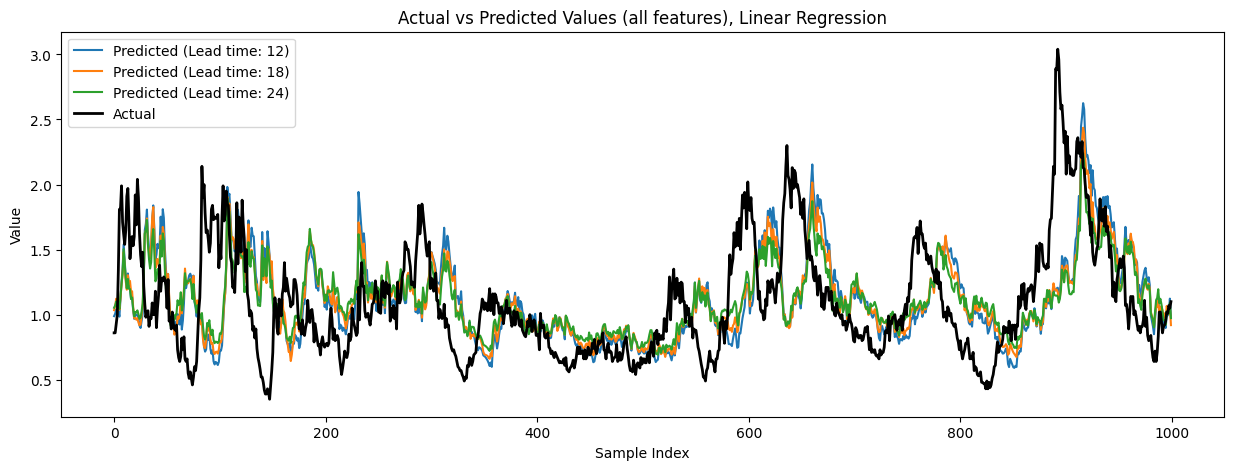

In [15]:
import matplotlib.pyplot as plt

N = 1000  

plt.figure(figsize=(15, 5))

for lead, (model, predictions, mse) in models.items():
    plt.plot(predictions[:N], label=f'Predicted (Lead time: {lead})')

plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

plt.title('Actual vs Predicted Values (all features), Linear Regression')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

As we can see, all different lead times follow the same general pattern – they all mimic the actual wave heights, just a few time steps later. This is because our model suffers from lagging, i.e. it is predicting current wave heights by upweighting previously seen data.

### Simple XGBoost

In [16]:
from xgboost import XGBRegressor

leads = [12, 18, 24]
boost = {}
for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_val = datasets[lead]['val'][0]
    y_val = datasets[lead]['val'][1]

    bst = XGBRegressor(n_estimators=1000, max_depth=6, eta=0.1, subsample=0.8, colsample_bytree=0.8)
    bst.fit(X_train, y_train)
    preds = bst.predict(X_val)  

    mse = mean_squared_error(y_val, preds)  
    print("Mean Squared Error:", mse)
    print("----------------")

    boost[lead] = (preds, mse)

Lead time: 12
Mean Squared Error: 0.06386358708483882
----------------
Lead time: 18
Mean Squared Error: 0.08865506138925743
----------------
Lead time: 24
Mean Squared Error: 0.10629567519030068
----------------


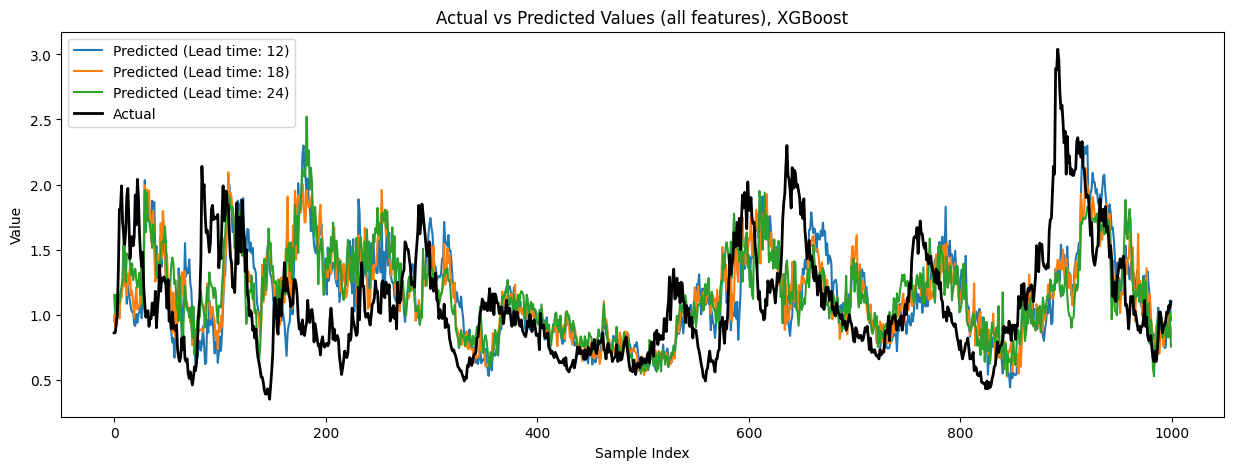

In [18]:
import matplotlib.pyplot as plt

N = 1000  

plt.figure(figsize=(15, 5))

for lead, (predictions, mse) in boost.items():
    plt.plot(predictions[:N], label=f'Predicted (Lead time: {lead})')

plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

plt.title('Actual vs Predicted Values (all features), XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Long Short-Term Memory

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

leads = [12, 18, 24]
lstm = {}
for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_val = datasets[lead]['val'][0]
    y_val = datasets[lead]['val'][1]

    timesteps = 48  
    number_of_features = 4
    X_train_reshaped = X_train.reshape(-1, timesteps, number_of_features)
    X_val_reshaped = X_val.reshape(-1, timesteps, number_of_features)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, number_of_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(lead)) 

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))
    predictions = model.predict(X_val_reshaped)

    lstm[lead] = (model, predictions, history)

Lead time: 12
Epoch 1/20
2061/2061 [==============================] - 31s 14ms/step - loss: 0.1365 - val_loss: 0.0885
Epoch 2/20
2061/2061 [==============================] - 30s 14ms/step - loss: 0.0958 - val_loss: 0.0859
Epoch 3/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0915 - val_loss: 0.0669
Epoch 4/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0896 - val_loss: 0.0673
Epoch 5/20
2061/2061 [==============================] - 28s 14ms/step - loss: 0.0873 - val_loss: 0.0680
Epoch 6/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0859 - val_loss: 0.0700
Epoch 7/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0843 - val_loss: 0.0703
Epoch 8/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0830 - val_loss: 0.0722
Epoch 9/20
2061/2061 [==============================] - 28s 14ms/step - loss: 0.0814 - val_loss: 0.0790
Epoch 10/20
2061/2061 [===========================

Below is the plot of the different LSTM sequences. Black is actual values, lead time 12 is orange, lead time 18 is light blue, and lead time 24 is red.

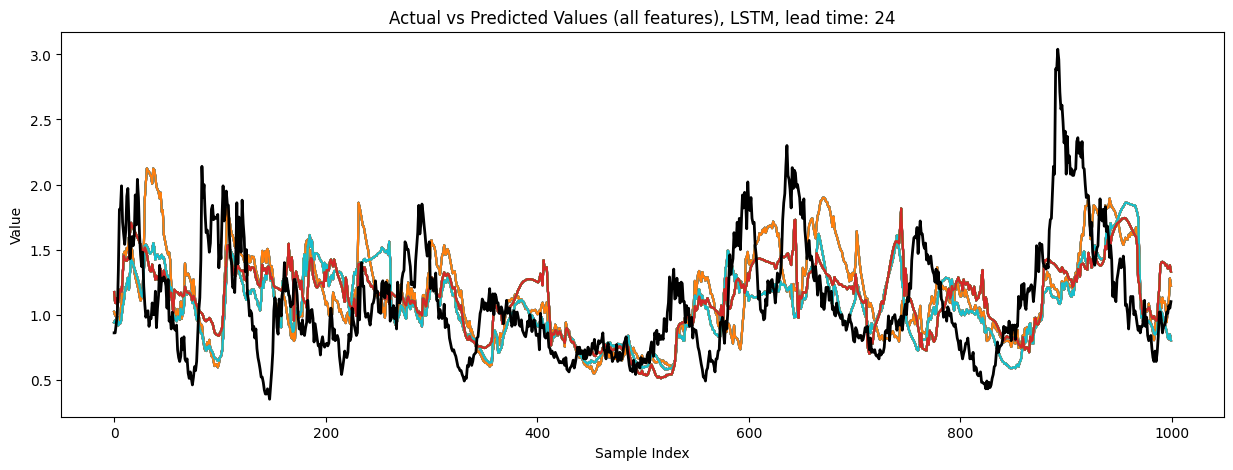

In [ ]:
import matplotlib.pyplot as plt

N = 1000  
timesteps = 48  
number_of_features = 4

plt.figure(figsize=(15, 5))

for lead, (model, predictions, history) in lstm.items():
    plt.plot(predictions[:1000], label=f'Predicted (Lead time: {lead})')

plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

plt.title(f'Actual vs Predicted Values (all features), LSTM')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


### Validate with the Test Set

Finally, we employ our LSTM on our testing set that we have withheld and evaluate its performance.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

leads = [12, 18, 24]
lstm_test = {}
for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_test = datasets[lead]['test'][0]
    y_test = datasets[lead]['test'][1]

    timesteps = 48  
    number_of_features = 4
    X_train_reshaped = X_train.reshape(-1, timesteps, number_of_features)
    X_val_reshaped = X_val.reshape(-1, timesteps, number_of_features)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, number_of_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(lead)) 

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))
    predictions = model.predict(X_val_reshaped)

    lstm[lead] = (model, predictions, history)

Lead time: 12
Epoch 1/20
2061/2061 [==============================] - 31s 15ms/step - loss: 0.1449 - val_loss: 0.1110
Epoch 2/20
2061/2061 [==============================] - 30s 15ms/step - loss: 0.0981 - val_loss: 0.1113
Epoch 3/20
2061/2061 [==============================] - 30s 15ms/step - loss: 0.0913 - val_loss: 0.1128
Epoch 4/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0881 - val_loss: 0.1247
Epoch 5/20
2061/2061 [==============================] - 29s 14ms/step - loss: 0.0863 - val_loss: 0.1102
Epoch 6/20
   1/2061 [..............................] - ETA: 28s - loss: 0.0489

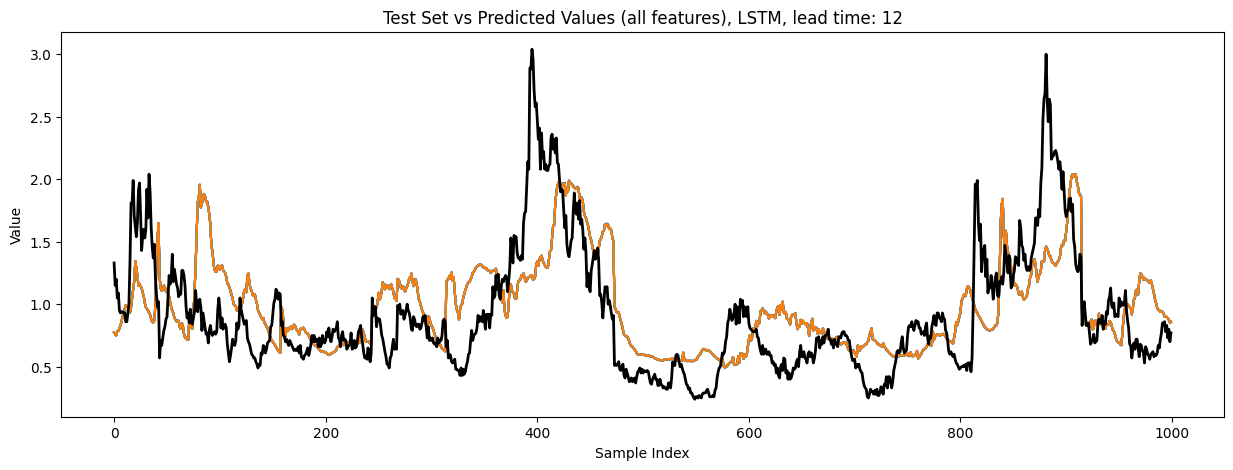

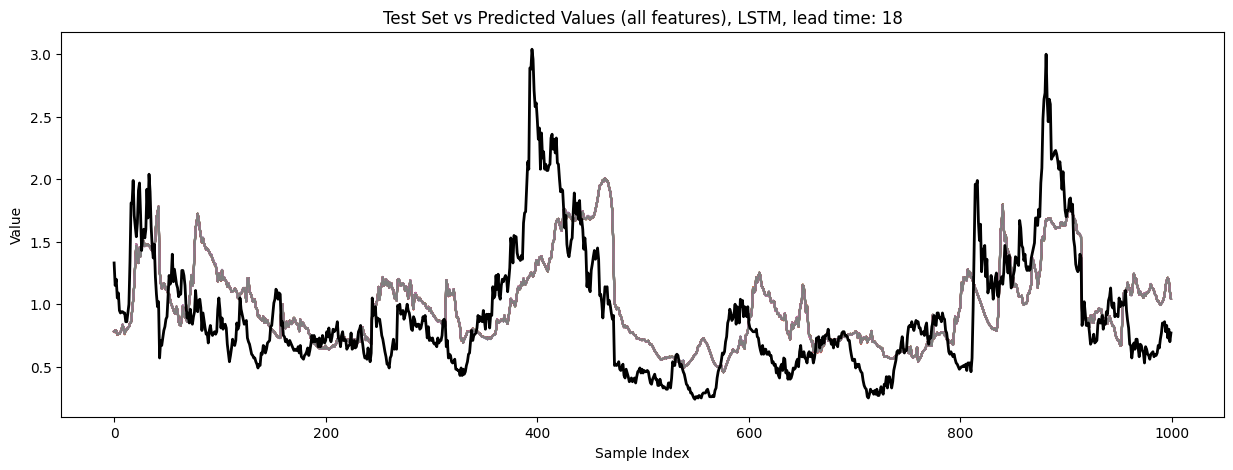

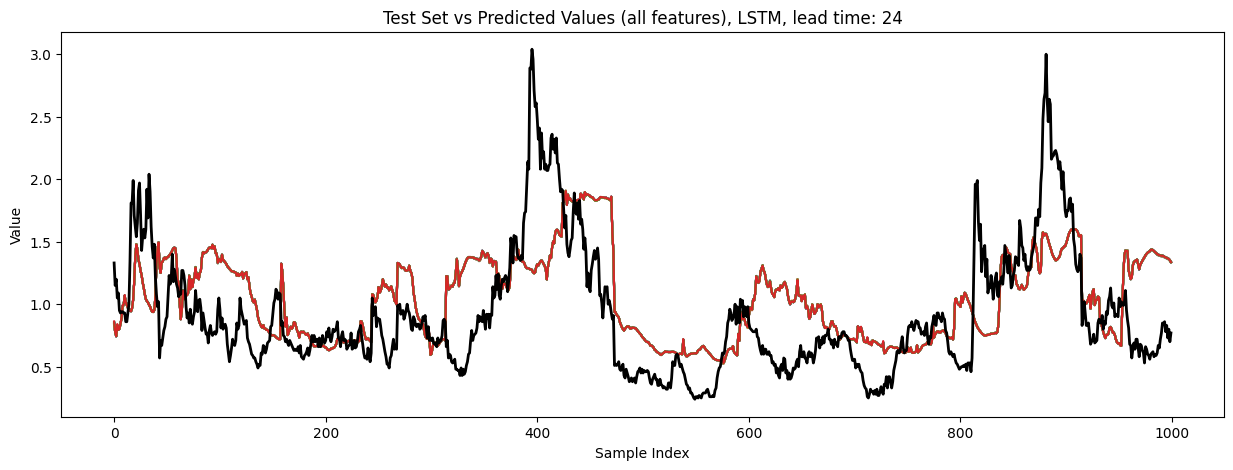

In [ ]:
import matplotlib.pyplot as plt

N = 1000  
timesteps = 48  
number_of_features = 4

for lead, (model, predictions, history) in lstm_test.items():
    plt.figure(figsize=(15, 5))

    y_test = datasets[lead]['test'][1]
    plt.plot(predictions[:N], label=f'Predicted (Lead time: {lead})')
    plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

    plt.title(f'Test Set vs Predicted Values (all features), LSTM, lead time: {lead}')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.show()

In [ ]:
import src.mlp as mlp

new_model = mlp.WaveForecastMLP(input_dim=48*4, dropout_rate=0.2)

# Load the weights from the file into the new model instance
new_model.load_state_dict(torch.load('model_1_weights.pth'))

# Ensure to call .eval() if you are in inference mode and you have layers like dropout or batchnorm in your model
new_model.eval()

WaveForecastMLP(
  (network): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
X_test = datasets[12]['test'][0]
y_test = datasets[18]['test'][1]
y_test

array([1.59, 1.66, 1.65, ..., 1.21, 1.33, 1.21])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

leads = [12, 18, 24]
models = {}

for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_test = datasets[lead]['test'][0]
    y_test = datasets[lead]['test'][1]

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print("Mean Squared Error:", mse)
    print("----------------")

    models[lead] = (model, predictions, mse)

Lead time: 12
Mean Squared Error: 0.06846957379904732
----------------
Lead time: 18
Mean Squared Error: 0.09122238690886565
----------------
Lead time: 24
Mean Squared Error: 0.10878850007159642
----------------


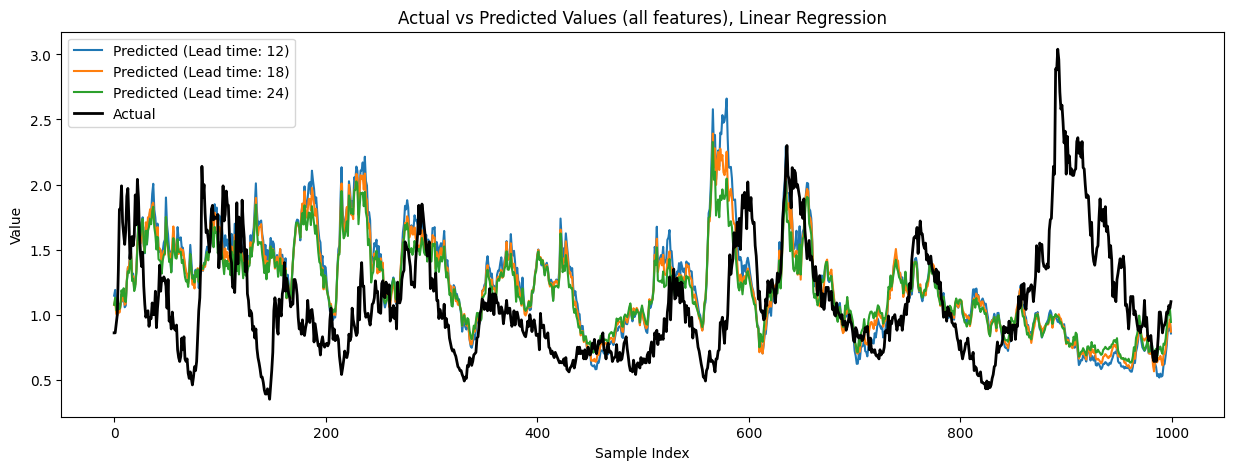

In [ ]:
import matplotlib.pyplot as plt

N = 1000  

plt.figure(figsize=(15, 5))

for lead, (model, predictions, mse) in models.items():
    plt.plot(predictions[:N], label=f'Predicted (Lead time: {lead})')

plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

plt.title('Actual vs Predicted Values (all features), Linear Regression')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()